# South African Language Identification Hack 2022

<a id="cont"></a>

## Table of contents

<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Packages</a>

<a href=#three>3. Loading Data</a>

<a href=#four>4. Exploratory Data Analysis</a>

<a href=#five>5. Feature Engineering</a>

<a href=#six>6. Model Building</a>

<a href=#seven>7. Model Evaluation</a>

<a href=#eight>8. Kaggle Model Submission</a>


# 1.1 Introduction

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable
tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and
political life of the South African society. With such a multilingual population, it is only obvious that our systems and
devices also communicate in multi-languages.

In this challenge,we will text which is in any of South Africa's 11 Official languages and identify which
language the text is in.

# 1.2 The Dataset

## Dataset Description

The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

## File descriptions

* `train_set.csv` - the training set

* `test_set.csv` - the test set

### Language IDs

* `afr` - Afrikaans

* `eng` - English

* `nbl` - isiNdebele

* `nso` - Sepedi

* `sot` - Sesotho

* `ssw` - siSwati

* `tsn` - Setswana

* `tso` - Xitsonga

* `ven` - Tshivenda

* `xho` - isiXhosa

* `zul` - isiZulu

<a id="one"></a>
 ## 2. Importing Packages
 <a href=#cont>Back to Table of Contents</a>

 ---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section, necessary packages to be used throughout the notebook are imported, and briefly discussed. |
| The imported libraries are used in the following stages of the data science process : data cleaning, exploratory data analysis and data modelling. |

---

In [13]:
import string 
import re
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools

 <a id="one"></a>
 ## 3. Loading Data
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section, the datasets to be used in the modelling process are loaded into DataFrames using the pandas library. |

---

In [2]:
train_df=pd.read_csv('train_set.csv')
test_df=pd.read_csv('test_set.csv')

In [3]:
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
train_df.tail()

,lang_id,text
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...


<a id="one"></a>
 ## 4. Exploratory Data Analysis
 
 <a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, an in-depth analysis of all the variables in the DataFrame is performed. |
| This phase of the project cycle is very important; it offers insight into the data, and any underlying patterns within it, |
| as well as any errors, duplicates or outliers present. |
| It is essential in understanding the data objectively and guides the data pre-processing and modelling processes. |
| The investigations conducted include: the dimensionality of the data, the descriptive statistics, data completeness, | 
| data distribution, existence of outliers and duplicates, as well as tweet entity extraction, analysis and visualisation.|

---



In [5]:
train_df.describe(include='all')

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [6]:
#check for null rows
train_df.isnull().sum()

lang_id    0
text       0
dtype: int64

There are 11 different languages in this dataset, so let's check the value count for each language

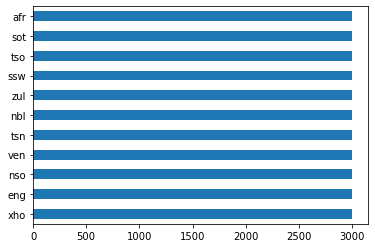

In [7]:
train_df['lang_id'].value_counts().plot.barh();

The label class is balanced as we can see so we do not need to resample it. Let go ahead with our feature engineering

 <a id="one"></a>
 ## 5. Feature Engineering
<a href=#cont>Back to Table of Contents</a>

### 5.1 Text Cleaning

Removing noise (i.e. unneccesary information) is a key part of getting the data into a usable format.  For this dataset, we will be carrying out the following cleaning techniques:

* removing the web urls(if any)

* converting all text into lowercase

* removing punctuation marks

* removing stopwords from tweets

In [10]:
#let us check for rows with URL links
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
train_df.loc[train_df['text'].str.contains(pattern_url, regex=True )] 

,lang_id,text


there seem to be no URl in this dataset.

In [11]:
#Convert the text into lower case
train_df['text'] = train_df['text'].str.lower() 
test_df['text'] = test_df['text'].str.lower() 

In [14]:
#Remove punctuation marks from the dataset
def punc_remover(text):
    return ''.join([l for l in text if l not in string.punctuation])

train_df['text'] = train_df['text'].apply(punc_remover)
test_df['text'] = test_df['text'].apply(punc_remover)

## 5.2 Feature Extraction

In [15]:
#separate to features and columns
corpus = train_df['text']
y = train_df['lang_id']
corpus_test=test_df['text']

### Label Encoding
Our output variable, `lang_id` is a categorical variable. For training the model we should have to convert it into a numerical form, so we are performing label encoding on that output variable. For this process, we are importing LabelEncoder from sklearn.

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### Bag of Words
The output feature and also the input feature should be of the numerical form. So we are converting text into numerical form by creating a Bag of Words model using `CountVectorizer`.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X= cv.fit_transform(corpus)
X_pred=cv.transform(corpus_test)

print(X.shape)
print(X_pred.shape)

(33000, 144198)
(5682, 144198)


### Train Test Splitting

The next step is to create the training set, for training the model and test set, for evaluating the test set. For this process, we are using a train test split.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

<a id="one"></a>
 ## 6. Model Building
 <a href=#cont>Back to Table of Contents</a>

Finally! The sweet stuff!

In this section, we shall;

* Build machine learning models

* Fit the machine learning models with training data

For this dataset, we will be using the naive_bayes algorithm for our model creation. 

In [19]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id="one"></a>
 ## 7. Model Evaluation
 <a href=#cont>Back to Table of Contents</a>

Let us take a look at the performance of our model.

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy is :",ac)

Accuracy is : 0.9993939393939394


Our model performed quite well with an accuracy score of 99.9% which is pretty incredible. let's now build a confusion matrix of our predictions

In [23]:
matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix: \n', matrix)

Confusion matrix: 
 [[632   0   0   0   0   0   0   0   0   0   0]
 [  0 607   0   0   0   0   0   0   0   0   0]
 [  0   0 622   0   0   0   0   0   0   0   2]
 [  0   0   0 626   1   0   0   0   0   0   0]
 [  0   0   0   0 624   0   0   0   0   0   0]
 [  0   0   0   0   0 575   0   0   0   0   0]
 [  0   0   0   0   0   0 560   0   0   0   0]
 [  0   0   0   0   0   0   0 615   0   0   0]
 [  0   0   0   0   0   0   0   0 584   0   0]
 [  0   0   0   0   0   0   0   0   0 540   0]
 [  0   1   0   0   0   0   0   0   0   0 611]]


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Actual labels',
                          cmap=plt.cm.Blues):
    """   
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


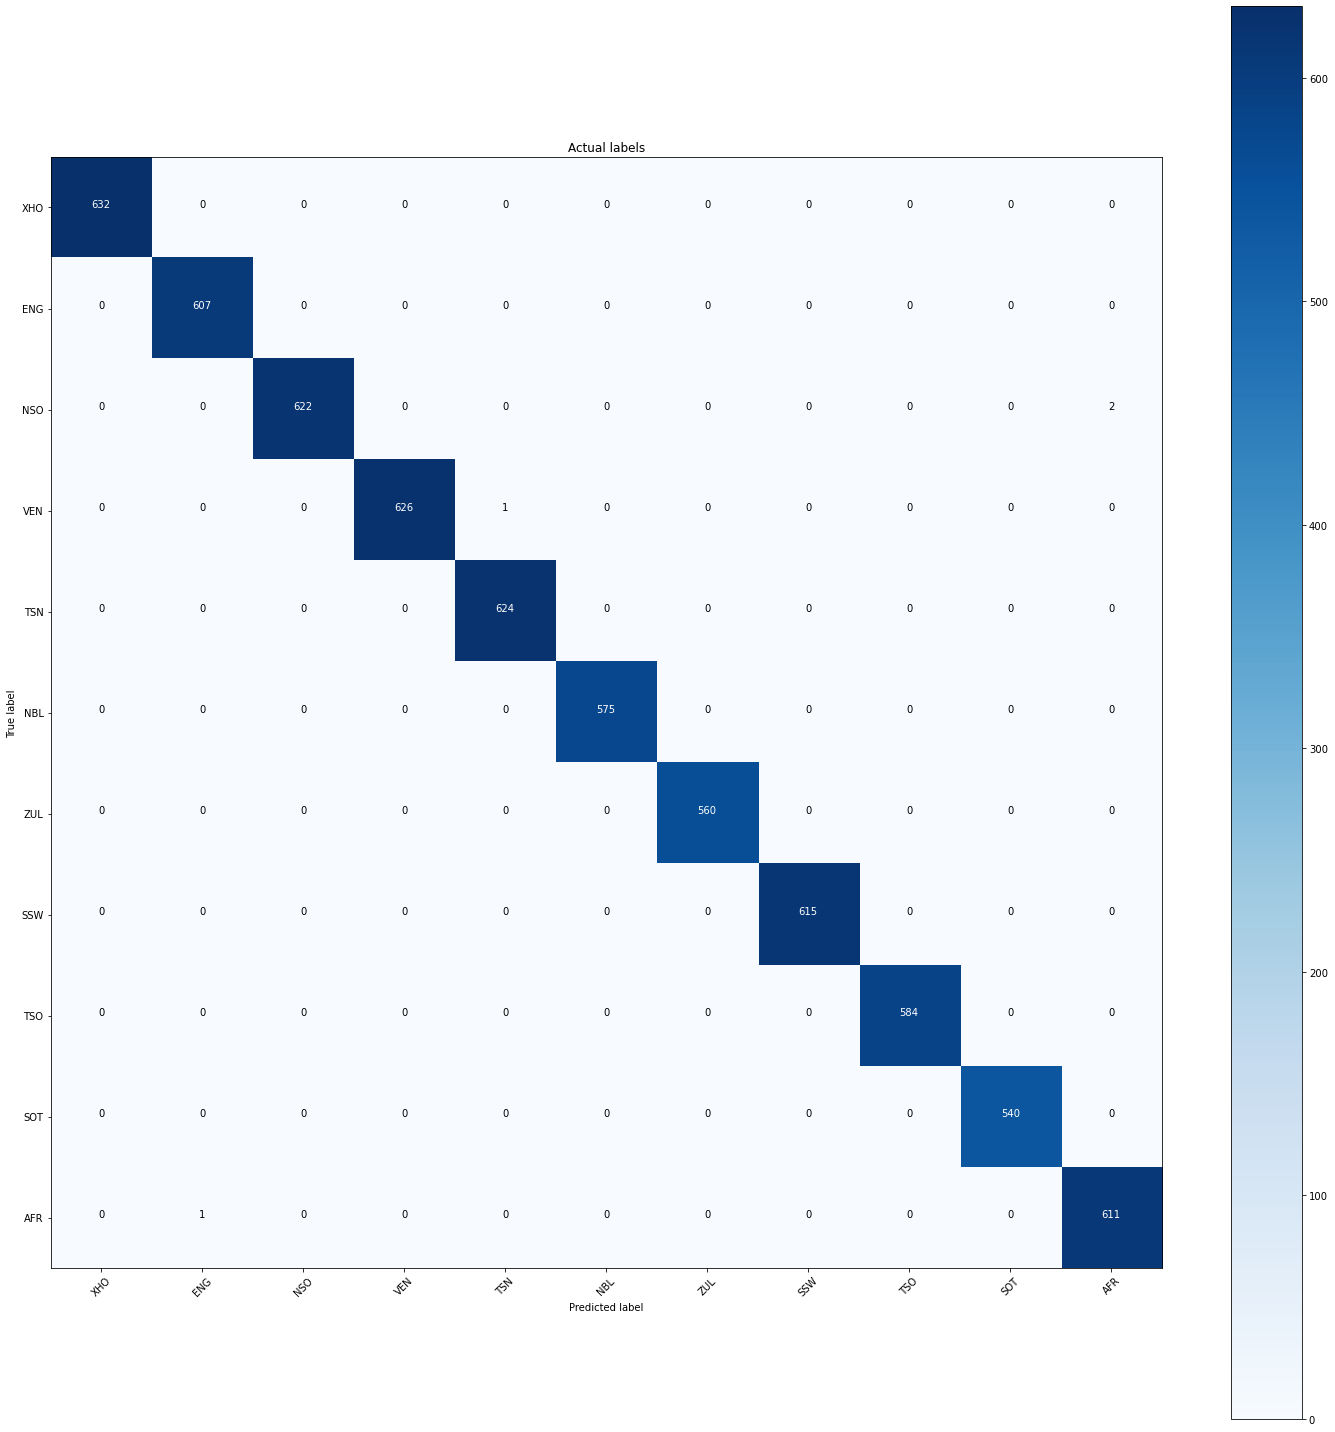

In [25]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(matrix, classes=['XHO','ENG','NSO','VEN','TSN','NBL','ZUL','SSW','TSO','SOT','AFR'])

<a id="one"></a>
 ## 8. Kaggle Predict Submission
 <a href=#cont>Back to Table of Contents</a>

let's prepare the csv file that we will submit to kaggle for the competition.

In [21]:
# Generate predictions
pred_test = model.predict(X_pred)

In [22]:
# Create csv file

index=test_df['index']
model_df = pd.DataFrame({'index':index, 'lang_id':pred_test})


model_df.to_csv('submission.csv', index=False)

model_df.head(10)

,index,lang_id
0,1,6
1,2,2
2,3,8
3,4,5
4,5,0
5,6,3
6,7,1
7,8,4
8,9,10
9,10,1
